<a href="https://colab.research.google.com/github/SRIDEV93/Language-Translation-Using-Machine-Learning-Telugu-to-English-/blob/main/Final_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries required

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import re
import time

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds

**Uploading Files**

In [ ]:
with open("Telugu.txt",mode='r',encoding='utf-8') as f:
  tel = f.read()

In [ ]:
with open("English.txt",mode='r',encoding='utf-8') as f:
  eng = f.read()

In [ ]:
with open("nonbreaking_prefix.te",mode='r',encoding='utf-8')as f:
  prefix_tel = f.read()

In [ ]:
with open("nonbreaking_prefix.en",mode='r',encoding='utf-8') as f:
  prefix_eng = f.read()

**Data Cleaning**

In [ ]:
prefix_tel = prefix_tel.split("\n")
print('Before adding space and period:')
print(prefix_tel[len(prefix_tel)-6:])
print()

prefix_tel = [' ' + pref + '.' for pref in prefix_tel]
print("After adding space and period: ")
print(prefix_tel[len(prefix_tel)-6:])

prefix_eng = prefix_eng.split('\n')
prefix_eng = [' ' + pref + '.' for pref in prefix_eng]

Before adding space and period:
['ష', 'స', 'హ', 'ళ', 'క్ష', 'ఱ']

After adding space and period: 
[' ష.', ' స.', ' హ.', ' ళ.', ' క్ష.', ' ఱ.']


**Removing Consecutive Spaces from the corpus**

In [ ]:
corpus_te = tel

for prefix in prefix_tel:
  corpus_te = corpus_te.replace(prefix,prefix + '$$$')

In [ ]:
corpus_te = re.sub(r"\.(?=[0-9]|[a-z]|[A-Z])",".$$$",corpus_te)

In [ ]:
corpus_te = re.sub(r".\$\$\$",'',corpus_te)

In [ ]:
corpus_te = re.sub(r"  +"," ",corpus_te)

In [ ]:
corpus_te = corpus_te.split('\n')

In [ ]:
corpus_en = eng

for prefix in prefix_eng:
  corpus_en = corpus_en.replace(prefix,prefix + '$$$')

In [ ]:
corpus_en = re.sub(r"\.(?=[0-9]|[a-z]|[A-Z])",".$$$",corpus_en)
corpus_en = re.sub(r".\$\$\$"," ",corpus_en)
corpus_en = re.sub(r"  +"," ",corpus_en)
corpus_en = corpus_en.split("\n")

**Tokenization**

In [ ]:
tokenizer_te = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    corpus_te, target_vocab_size=2**13)

In [ ]:
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    corpus_en, target_vocab_size=2**13)

In [ ]:
VOCAB_SIZE_TE = tokenizer_te.vocab_size + 2
VOCAB_SIZE_EN = tokenizer_en.vocab_size + 2

In [ ]:
inputs = [[VOCAB_SIZE_TE-2] + tokenizer_te.encode(sentence) + [VOCAB_SIZE_TE-1] for sentence in corpus_te]

outputs = [[VOCAB_SIZE_EN-2] + tokenizer_en.encode(sentence) + [VOCAB_SIZE_EN-1] for sentence in corpus_en]

**Removing long sentences from the corpus**

In [ ]:
MAX_LENGTH = 40

idx_to_remove = [count for count, sent in enumerate(inputs)
                  if len(sent) > MAX_LENGTH]

for idx in reversed(idx_to_remove):
  del inputs[idx]
  del outputs[idx]

idx_to_remove = [count for count, sent in enumerate(outputs)
                  if len(sent) > MAX_LENGTH]

for idx in reversed(idx_to_remove):
  del inputs[idx]
  del outputs[idx]

**Padding**

In [ ]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,value=0,padding='post',maxlen=MAX_LENGTH)
outputs = tf.keras.preprocessing.sequence.pad_sequences(outputs,value=0,padding='post',maxlen=MAX_LENGTH)

In [ ]:
len(inputs)


134564

In [ ]:
len(outputs)

134564

In [ ]:
134567*2

269134

**Final Dataset for the model**

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 270000

dataset = tf.data.Dataset.from_tensor_slices((inputs,outputs))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## **Model Building**
To build this model, there are three basic components required.
1. Positional Encoding
2. Self-Attention layers
3. Point-wise feed forward network layers

Multilayered encoders and decoders are created based on these components







**Positional encoding**

The Formula for postional encoding is 
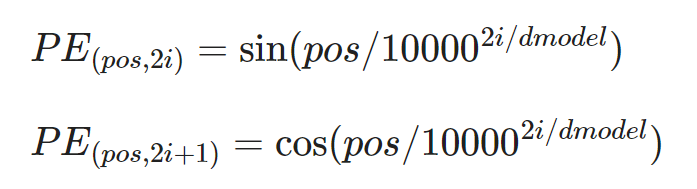
Calculating an angle is to use the formula pos/10000**(2i/dmodel). If the angle is sine or cosine, then take that value. It gives the embedding index(i) and the position of the word (pos). The embedding index(i) increases as the position of the word remains constant, resulting in unique pattern. Each time a wor is reached the position increments. The pattern then slightly shifts to the right. When the embedding index is even (i), the since function is applied, when it is odd, cosine function is applied

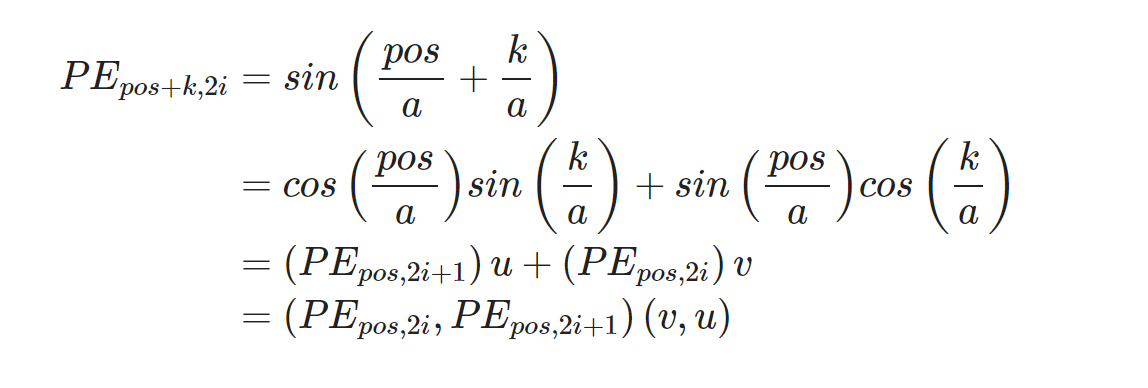

As long as k is fixed, sin(k/a) and cos(k/a) are constants, PE[pos+k] is a matrix that is dependent on k times PE_pos


In [ ]:
class PositionalEncoding(layers.Layer):

    def __init__(self):
        super(PositionalEncoding, self).__init__()
    
    def get_angles(self, pos, i, d_model):
        '''
        pos     - (seq_length, 1) matrix
        i       - (1, d_model) matrix
        d_model - the size of the embedding vectors
        '''
        angles = 1 / np.power(10000., (2*(i//2)) / np.float32(d_model))
        return pos * angles

    def call(self, inputs):
        ''' 
        inputs - the word embeddings - (batch_size, seq_length, d_model)
        '''
        seq_length = inputs.shape.as_list()[-2]
        d_model = inputs.shape.as_list()[-1]
        
        angles = self.get_angles(np.arange(seq_length)[:, np.newaxis],
                                 np.arange(d_model)[np.newaxis, :],
                                 d_model)
        
        # Interleve the results of sine and cosine funtions along the embedding vectors
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        
        # Add dimension for batch_size
        pos_encoding = angles[np.newaxis, ...]
        return inputs + tf.cast(pos_encoding, tf.float32)

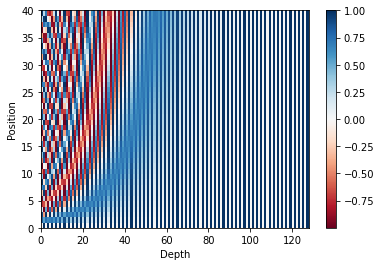

In [ ]:
pos_encoding = PositionalEncoding().call(tf.zeros([1, 40, 128], tf.float32))

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

**Attention Calculation**

The step-by-step procedure to calculate the self-attention
1. Calculate the dot product of the query vector with the transpose of each word key vector, including the query vector itself. The attentio score is the result of this calculation.
2. Each result is divided by the square root of the key vector dimension. The result is the scaled attention score.
3. To get values between 0 and 1, pass the values through a softmax function.
4. Add the output of the Softmax function to each of the value vectors.
5. Combine all the weighted value vectors.

In [ ]:
#
# Calculate attention
#
def scaled_dot_product_attention(queries, keys, values, mask):
    '''
    Takes three vectors and mask
    Returns the attention and attention weights
    '''    
    # The steps describe above under 'Calculate the Attention' 
    # Step 1 
    product = tf.matmul(queries, keys, transpose_b=True)
    
    # Step 2
    keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32)
    scaled_product = product / tf.math.sqrt(keys_dim)
    
    if mask is not None:
        scaled_product += (mask * -1e9)
    
    # step 4
    attention_weights =tf.nn.softmax(scaled_product, axis=-1)
    
    # Step 5
    attention = tf.matmul(attention_weights, values)
    
    return attention, attention_weights

**Multi-Headed attention layer**

During this phase, everything previously discussed is put into action. The following is an overview of its functions.

1. Instantiates four dense layers.
2. Three dense layers transform the input into a query vector, key and a value vector.
3. Dividing each vector according to the number of heads.
4. Calculate attentions per head using scaled_dot_product_attention().
5. Then combine the attentions obtained from each head.
6. After passing the results through a dense layer, the attention vector is reshaped back to (batch size, seq_length, d_model).
7. The attention vector and weights are returned.

In [ ]:
class MultiHeadAttention(layers.Layer):
    
    # nb_proj is the number of heads
    def __init__(self, nb_proj):
        super(MultiHeadAttention, self).__init__()
        self.nb_proj = nb_proj
        
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        assert self.d_model % self.nb_proj == 0
        
        # Calculate the head dimensions.
        self.d_proj = self.d_model // self.nb_proj
        
        # These layers contain the weights for the linear transformations
        self.query_lin = layers.Dense(units=self.d_model)
        self.key_lin = layers.Dense(units=self.d_model)
        self.value_lin = layers.Dense(units=self.d_model)
        
        # Used to transform after concatenating the weighted value vectors
        self.final_lin = layers.Dense(units=self.d_model)
    
    # This method splits the query, key, and value vectors by the number of heads
    def split_proj(self, inputs, batch_size): # inputs: (batch_size, seq_length, d_model)
        shape = (batch_size,
                 -1,
                 self.nb_proj,
                 self.d_proj)
        
        # Reshape the tensor to account for the multiple heads and reduced vector dimension
        splited_inputs = tf.reshape(inputs, shape=shape) # (batch_size, seq_length, nb_proj, d_proj)
        
        # Reconfigure the axeses.
        return tf.transpose(splited_inputs, perm=[0, 2, 1, 3]) # (batch_size, nb_proj, seq_length, d_proj)
    
    def call(self, queries, keys, values, mask):
        '''
        If this is the first attention layer of the encoder, then all vector inputs are the same vector.
        For later layers, this is the output of the previous layer.
        For the decoder, keys and values are the output of the encoder. 
            The queries is the inferred words up to this time step.        
        '''
        batch_size = tf.shape(queries)[0]
        
        # Initialize the weight matrices
        queries = self.query_lin(queries)
        keys = self.key_lin(keys)
        values = self.value_lin(values)
        
        # Split the vectors by number of heads
        queries = self.split_proj(queries, batch_size)
        keys = self.split_proj(keys, batch_size)
        values = self.split_proj(values, batch_size)
        
        # Get attention and weights
        attention, attention_weights = scaled_dot_product_attention(queries,
                                                                    keys,
                                                                    values,
                                                                    mask)
        # Flip dims 1 and 2       
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        
        # Concat all the attention vectors
        concat_attention = tf.reshape(attention,
                                      shape=(batch_size, -1, self.d_model))
        
        # Transform the concated vectors to reshape back to (batch_size, seq_length, d_model)
        outputs = self.final_lin(concat_attention)
        
        return outputs, attention_weights

**Encoder Layer Class**

This layer's functions are sunnarized in the following steps.
1. The attention layer is created by instatiating two objects: a multi-head attention objet and a dropout object.
2. This layer consists of 2 dense objects, a dropout object, and a normalization object.
3. Shape inputs are batch size, sequence length, and the model, the mask, and a boolean for the dropout.
4. The attention calculation is done by passing both input and mask to the multi-head attention object.
5. Attention is passed using dropout object.
6. Then normalize the input to get the attention calculation.
7. The output will have the following: batch size, sequence length and model.

In [ ]:
class EncoderLayer(layers.Layer):
    
    def __init__(self, FFN_units, nb_proj, dropout_rate):
      super(EncoderLayer, self).__init__()
      self.FFN_units = FFN_units
      self.nb_proj = nb_proj
      self.dropout_rate = dropout_rate
    
    # This is a tensorflow layers method. Automatically called by __call__
    # to automatically build the layers.
    def build(self, input_shape):
        
        self.d_model = input_shape[-1]
    
        # Multi-head attention
        self.multi_head_attention = MultiHeadAttention(self.nb_proj)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        
        # Point wise feed forward
        self.dense_1 = layers.Dense(units=self.FFN_units, activation="relu")
        self.dense_2 = layers.Dense(units=self.d_model)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, mask, training):
        '''
        inputs   -> Input tensor of shape (batch_size, seq_length, d_model)
        mask     -> Padding mask to ignore padding zeros as data
        training -> Boolean - If 1, then use dropout, else not
        '''
        # Attention sub-layer
        # Retain only the attention. Don't need to return weights in this layer.
        attention, _ = self.multi_head_attention(inputs,
                                                 inputs,
                                                 inputs,
                                                 mask)
        attention = self.dropout_1(attention, training=training)
        attention = self.norm_1(attention + inputs)
        
        # Point-Wise Feed Forward sub-layer
        outputs = self.dense_1(attention)
        outputs = self.dense_2(outputs)
        outputs = self.dropout_2(outputs, training=training)
        outputs = self.norm_2(outputs + attention)
        
        # Returns tensor of shape (batch_size, seq_length, d_model)
        return outputs

**Encoder Class**

Stacks of encoder layers make up the full encoder. Stacked Encoder is the implementation of this class. Moreover, It supports positional encoding and embedding. As a result, the encoder stack produces the output. The encoder performs the following operations.

1. Creates a layer of embedding.
2. Positional encoding object is initialized.
3. Dropout layer is created.
4. Number of encoding layers created by nb_layers
5. Shape input with (batch size, seq-length), attention mask, and boolean output.
6. A tensor of shape is produced with batch size,seq_length, and d_model (from the input), which is passed through the embedding layer.
7. Creating the vectors representing the positional encoding.
8. Embeds the positional encoding vectors in the embedding vectors.
9. This step passes the corresponding input tensor, mask, and the training boolean to the encoding layer stack.
10. Iterating over the layers of stacked encoders.
11. A tensor shape (batch size, seq_length, d_model) is returned.

The code looks like this.

outputs = self.Embedding(inputs)

outputs = tf.math.sqrt(tf.cast(self.d_model,tf.float32))

outputs = self.pos_encoding(outputs)

In [ ]:
class Encoder(layers.Layer):
    '''
    nb_layers    -> Number of encoder layers
    FFN_units    -> Number of nodes in the FFN
    nb_proj      -> Number of attention heads
    dropout_rate -> Droput rate
    vocab_size   -> The size of the vocabulary
    d_model      -> Size of embedding vectors
    name         -> Name of the layer
    '''    
    def __init__(self,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="encoder"):
        super(Encoder, self).__init__(name=name)
        
        # Number of encoder layers
        self.nb_layers = nb_layers
        # Embedding dimension
        self.d_model = d_model
        
        # Initialize embedding, positional encoding, droppout, and encoding layers
        self.embedding = layers.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.enc_layers = [EncoderLayer(FFN_units,
                                        nb_proj,
                                        dropout_rate) 
                           for _ in range(nb_layers)]
    
    def call(self, inputs, mask, training):
        '''
        inputs   -> Tokenized input of shape (batch_size, seq_length)
        mask     -> Attention mask
        training -> Boolean
        '''
        outputs = self.embedding(inputs)
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        
        # Forward pass
        for i in range(self.nb_layers):
            outputs = self.enc_layers[i](outputs, mask, training)

        # Returns tensor of shape (batch_size, seq_length, d_model)
        return outputs

**Decoder Layer Class**

There are three stacked sub-layers in a decoder layer, as mentioned previously. In the first two layers, multi-head self-attention layers are used, and in the third a FFN is used. Decoder Layer is implemented by this class. What it does is summarized below.

1. In the instantiation method, the number of heads, the number of nodes, and the dropout rate for the FFN is collected.

2. Adds a drop-out layer and a normalization layer to the masked multi-head self-attention sublayer

3. Adds a dropout layer, an attention sub-layer, and a notification layer to the encoder-decoder multi-head self-attention layer

4. Adds two dense layers, a dropout layer, and a nomination layer to the point-wise FNN sub-layer.

5. Decoder layer output is accepted, as are the encoder output, look-ahead masks, padding masks, and a Boolean output.

6. In training, the first decoding layer uses the entire target sequence as input. The decoder's final output is used in inferencing. Look-ahead mask is also taken into account.

7. Then, the dropout is applied to the attention vector.

8. Adding the input to the attention vector

9. Then normalize

10. Two instances of encoder output, and the padding mask are passed as the first argument to the second attention layer along with the output (attention vector) of the first attention layer.

11. Dropout is applied to the attention vector.

12. Combine the first attention vector with the new attention vector.

13. Then normalize

14. Incorporate the updated attention vector into the FFN

15. And then apply the dropout

16. For the output, the second attention vector is added

17. Then Again Normalize

18. Tensor shape (batch size, sequence length and d_model) are returned.

In [ ]:
class DecoderLayer(layers.Layer):
    '''
    FFN-units    -> # of nodes for the point wise feed forward layer
    nb_proj      -> # of heads
    dropout_rate -> The dropout rate for the layers
    '''
    def __init__(self, FFN_units, nb_proj, dropout_rate):
        super(DecoderLayer, self).__init__()
        self.FFN_units = FFN_units
        self.nb_proj = nb_proj
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        
        # Masked Multi-head attention layer
        self.multi_head_attention_1 = MultiHeadAttention(self.nb_proj)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        
        # encoder-decoder Multi-head attention
        self.multi_head_attention_2 = MultiHeadAttention(self.nb_proj)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
        # Feed foward
        self.dense_1 = layers.Dense(units=self.FFN_units,
                                    activation="relu")
        self.dense_2 = layers.Dense(units=self.d_model)
        self.dropout_3 = layers.Dropout(rate=self.dropout_rate)
        self.norm_3 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        '''
        input       -> Decoder output
        enc_outputs -> Encoder output
        mask_1      -> Look-ahead mask
        mask_2      -> Padding mask
        training    -> Boolean for dropout
        '''
        # Masked Multi-head attention layer 
        # Return attention, attention weights
        attention, attn_wt_1 = self.multi_head_attention_1(inputs,
                                                           inputs,
                                                           inputs,
                                                           mask_1)
        attention = self.dropout_1(attention, training)
        attention = self.norm_1(attention + inputs)
        
        # Encoder-Decoder Multi-head attention layer 
        # Return attention, attention weights
        attention_2, attn_wt_2 = self.multi_head_attention_2(attention,
                                                             enc_outputs,
                                                             enc_outputs,
                                                             mask_2)
        attention_2 = self.dropout_2(attention_2, training)
        attention_2 = self.norm_2(attention_2 + attention)
        
        # FNN
        outputs = self.dense_1(attention_2)
        outputs = self.dense_2(outputs)
        outputs = self.dropout_3(outputs, training)
        outputs = self.norm_3(outputs + attention_2)
        
        # Return attention vector, attention weights for each attention layer
        return outputs, attn_wt_1, attn_wt_2

**Decoder Class**

There are several layers of decoding in a full decoder. The decoder stack is implemented in this class. Additionally, it also implements embedded and positional encoding. The output of the encoder stack is the encoded data.

Let's examine what it does in more detail.

1. The decoder creates an embedding layer.

2. Positional encoding object is initialized.

3. Then, creating a dropout layer.

4. nb_layers specify the number of decoding layers to create

5. Obtains the encoder output, the decoder layer output, the look-ahead mask, the padding mask, and a Boolean from the pair of (batch size, target_seq_length) shapes

6. The input is made into a tensor of shape by passing it through the embedding layer (batch size, sequence length, d_model).

7. This function produces the positional encoding vectors

8. The embedding vectors are enhanced with positional encoding vectors.

9. A stack consisting of the output of the decoder, the input tensor, and the Boolean for training is passed to an encoder.

10. This iteration occurs throughout the decoding layer stack.

11. The output tensor of shape includes the batch size, target sequencing length, and the attention weights.

The following formulas are used in the code.

   outputs = self. Embedding(inputs)

   outputs *= tf. math.sqrt(tf.cast(self.d_model, tf.float32))

   outputs = self.pos_encoding(outputs)

In [ ]:
class Decoder(layers.Layer):
    '''
    nb_layers    -> Number of encoder layers
    FFN_units    -> Number of nodes in the FFN
    nb_proj      -> Number of attention heads
    dropout_rate -> Droput rate
    vocab_size   -> The size of the vocabulary
    d_model      -> Size of embedding vectors
    name         -> Name of the layer
    '''    
    def __init__(self,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="decoder"):
        super(Decoder, self).__init__(name=name)
        self.d_model = d_model
        self.nb_layers = nb_layers
        
        self.embedding = layers.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout_rate)
        
        # Initialize the decoder layers.
        self.dec_layers = [DecoderLayer(FFN_units,
                                        nb_proj,
                                        dropout_rate) 
                           for i in range(nb_layers)]
    
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        '''
        input       -> Decoder output
        enc_outputs -> Encoder output
        mask_1      -> Look-ahead mask
        mask_2      -> Padding mask
        training    -> Boolean for dropout
        '''
        outputs = self.embedding(inputs)
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training)
        
        # Iterate over the decoder layers.
        for i in range(self.nb_layers):
            
            attention_weights = {}

            # Block 1 and block2 are the attention weights from each attention head of the layer
            outputs, block1, block2 = self.dec_layers[i](outputs, enc_outputs, mask_1, mask_2, training)
            
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2


        return outputs, attention_weights

**Transformers**


It's finally here! The full transformer!

The transformer is where everything comes together. Here's an explanation of what it does.

In a Transformers class, the step-by-step explanation is given below.       
1. First step is to initialize the encoder and the decoder.
      
2. Then using vocab_size_decoder as the number of nodes, create the output linear layer
3. Now, padding is created to look -ahead for masks.
4. Then, these arguments are passed into the encoder and the output of that attention matrix is captured.
5. Again, these arguments are passed into the decoder and the output of that attention matrix is captured.
6. The output of the decoder is passed into the final dense layer, which returns the output of shape (batch size, target sequence length, target vocab size).
7. Finally, returning the prediction (batch size, target_sequence_length,
target_vocab_size) and the attention weight matrix.


In [ ]:
class Transformer(tf.keras.Model):
    '''
    vocab_size_enc -> Vocabulary size of the encoder input
    vocab_size_dec -> Vocabulary size of the decoder input
    d_model        -> Embedding size
    nb_layers      -> Number of encoder and decoder layers
    FFN_units      -> Noumber of nodes in the FNNs 
    nb_proj        -> Number of heads
    dropout_rate   -> Dropout rate throught model
    name           -> Layer name
    '''    
    def __init__(self,
                 vocab_size_enc,
                 vocab_size_dec,
                 d_model,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 dropout_rate,
                 name="transformer"):
        super(Transformer, self).__init__(name=name)
        
        self.encoder = Encoder(nb_layers,
                               FFN_units,
                               nb_proj,
                               dropout_rate,
                               vocab_size_enc,
                               d_model)
        
        self.decoder = Decoder(nb_layers,
                               FFN_units,
                               nb_proj,
                               dropout_rate,
                               vocab_size_dec,
                               d_model)
        
        self.last_linear = layers.Dense(units=vocab_size_dec, name="lin_ouput")
    
    def create_padding_mask(self, seq):
        
        mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return mask[:, tf.newaxis, tf.newaxis, :]

    def create_look_ahead_mask(self, seq):
        
        seq_len = tf.shape(seq)[1]
        look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        return look_ahead_mask
    
    def call(self, enc_inputs, dec_inputs, training):
        
        enc_mask = self.create_padding_mask(enc_inputs)
        dec_mask_1 = tf.maximum(
            self.create_padding_mask(dec_inputs),
            self.create_look_ahead_mask(dec_inputs)
        )
        dec_mask_2 = self.create_padding_mask(enc_inputs)
        
        # encoder output
        enc_outputs = self.encoder(enc_inputs, enc_mask, training)
        
        # dec_outputs, attention_weights
        dec_outputs, attention_weights = self.decoder(dec_inputs,
                                                      enc_outputs,
                                                      dec_mask_1,
                                                      dec_mask_2,
                                                      training)
        
        # This is the prediction
        outputs = self.last_linear(dec_outputs)
        
        # Return prediction (batch_size, tar_seq_len, target_vocab_size), and attention_weight matrix
        return outputs, attention_weights

**Training**

The following steps must be taken befor we train our model.
1. Hyper-parameters are to be defined.
2. Calculate the loss function
3. Create a customized learning rate schedule.
4. Preparing Adam Optimizer
5. Preparing checkpoint and checkpoint manager.

In [ ]:
tf.keras.backend.clear_session()

# Hyper-parameters
D_MODEL = 128 # 512
NB_LAYERS = 4 # 6
FFN_UNITS = 512 # 2048
NB_PROJ = 8 # 8
DROPOUT_RATE = 0.1 # 0.1

# Initialize the transformer
transformer = Transformer(vocab_size_enc=VOCAB_SIZE_TE,
                          vocab_size_dec=VOCAB_SIZE_EN,
                          d_model=D_MODEL,
                          nb_layers=NB_LAYERS,
                          FFN_units=FFN_UNITS,
                          nb_proj=NB_PROJ,
                          dropout_rate=DROPOUT_RATE)

**Loss Function**

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction="none")

def loss_function(target, pred):
    mask = tf.math.logical_not(tf.math.equal(target, 0))
    loss_ = loss_object(target, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")

**learning rate schedule**

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

leaning_rate = CustomSchedule(D_MODEL)

# Use the Adam Optimizer
optimizer = tf.keras.optimizers.Adam(leaning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

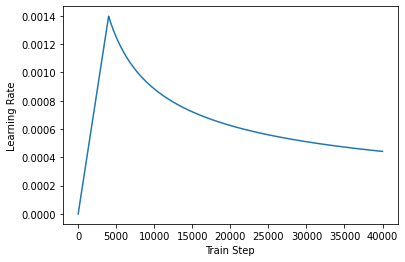

In [ ]:
plt.plot(leaning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
if os.path.isdir('../ckpt') is False:
    os.mkdir('../ckpt')

In [ ]:
checkpoint_path = "/ckpt/"
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!!")

**Training**

In [ ]:
EPOCHS = 10
for epoch in range(EPOCHS):
    print("Start of epoch {}".format(epoch+1))
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for (batch, (enc_inputs, targets)) in enumerate(dataset):
        
        # Include the start token which shifts sequence to the right
        dec_inputs = targets[:, :-1]
        
        # Target without the start token. The end token is included to know when the 
        # model reaches the end of the sequence
        dec_outputs_real = targets[:, 1:]
        
        with tf.GradientTape() as tape:
            predictions, _ = transformer(enc_inputs, dec_inputs, True)
            loss = loss_function(dec_outputs_real, predictions)
        
        # Calculate and apply the gradients
        gradients = tape.gradient(loss, transformer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
        
        train_loss(loss)
        train_accuracy(dec_outputs_real, predictions)
        
        if batch % 50 == 0:
            print("Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}".format(
                epoch+1, batch, train_loss.result(), train_accuracy.result()))
            
    ckpt_save_path = ckpt_manager.save()
    print("Saving checkpoint for epoch {} at {}".format(epoch+1,
                                                        ckpt_save_path))
    print("Time taken for 1 epoch: {} secs\n".format(time.time() - start))

Start of epoch 1
Epoch 1 Batch 0 Loss 2.1263 Accuracy 0.0000
Epoch 1 Batch 50 Loss 2.0112 Accuracy 0.0060
Epoch 1 Batch 100 Loss 1.9721 Accuracy 0.0158
Epoch 1 Batch 150 Loss 1.9373 Accuracy 0.0190
Epoch 1 Batch 200 Loss 1.9031 Accuracy 0.0207
Epoch 1 Batch 250 Loss 1.8628 Accuracy 0.0227
Epoch 1 Batch 300 Loss 1.8141 Accuracy 0.0267
Epoch 1 Batch 350 Loss 1.7621 Accuracy 0.0297
Epoch 1 Batch 400 Loss 1.7091 Accuracy 0.0325
Epoch 1 Batch 450 Loss 1.6577 Accuracy 0.0354
Epoch 1 Batch 500 Loss 1.6111 Accuracy 0.0383
Epoch 1 Batch 550 Loss 1.5668 Accuracy 0.0411
Epoch 1 Batch 600 Loss 1.5246 Accuracy 0.0439
Epoch 1 Batch 650 Loss 1.4848 Accuracy 0.0466
Epoch 1 Batch 700 Loss 1.4490 Accuracy 0.0492
Epoch 1 Batch 750 Loss 1.4150 Accuracy 0.0514
Epoch 1 Batch 800 Loss 1.3831 Accuracy 0.0537
Epoch 1 Batch 850 Loss 1.3540 Accuracy 0.0558
Epoch 1 Batch 900 Loss 1.3272 Accuracy 0.0577
Epoch 1 Batch 950 Loss 1.3027 Accuracy 0.0596
Epoch 1 Batch 1000 Loss 1.2798 Accuracy 0.0613
Epoch 1 Batch 1050 

**Evaluation**

In [ ]:
def evaluate(inp_sentence):
    '''
    Takes the input sentence.
    '''
    inp_sentence = [VOCAB_SIZE_TE-2] + tokenizer_te.encode(inp_sentence) + [VOCAB_SIZE_TE-1]
    
    # Expand dims to account for batch_size
    enc_input = tf.expand_dims(inp_sentence, axis=0)
    
    # Start with the s-o-s
    output = tf.expand_dims([VOCAB_SIZE_EN-2], axis=0)
    
    for _ in range(MAX_LENGTH):
        predictions, attention_weights = transformer(enc_input, output, False)
        
        prediction = predictions[:, -1:, :]
        
        # Get highest probability
        predicted_id = tf.cast(tf.argmax(prediction, axis=-1), tf.int32)
        
        # If e-o-s return
        if predicted_id == VOCAB_SIZE_EN-1:
            return tf.squeeze(output, axis=0), attention_weights
        
        # Concat last prediction to decoder input
        output = tf.concat([output, predicted_id], axis=-1)
        
    return tf.squeeze(output, axis=0), attention_weights

**Attention weights function**

In [ ]:
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))
    sentence = tokenizer_te.encode(sentence)
    attention = tf.squeeze(attention[layer], axis=0)

    for head in range(attention.shape[0]):

        ax = fig.add_subplot(2, 4, head+1)

        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')
        fontdict = {'fontsize': 10}
        
        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))
        ax.set_ylim(len(result)-1.5, -0.5)
        ax.set_xticklabels(
            ['<start>']+[tokenizer_te.decode([i]) for i in sentence]+['<end>'],
            fontdict=fontdict, rotation=90)

        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result
                            if i < VOCAB_SIZE_EN-2],
                           fontdict=fontdict)
        
        ax.set_xlabel('Head {}'.format(head+1))
    plt.tight_layout()
    plt.show()

**Translate Function**

In [ ]:
def translate(sentence, plot=''):
    #output, attention_weights
    output, attention_weights = evaluate(sentence) #.numpy()
    print(f'wts shape: {attention_weights.keys()}')
    output = output.numpy()
    
    predicted_sentence = tokenizer_en.decode(
        [i for i in output if i < VOCAB_SIZE_EN-2]
    )
    
    print("Input: {}".format(sentence))
    print("Predicted translation: {}".format(predicted_sentence))
    if plot:
        plot_attention_weights(attention_weights, sentence, output, plot)

**Google Translator**

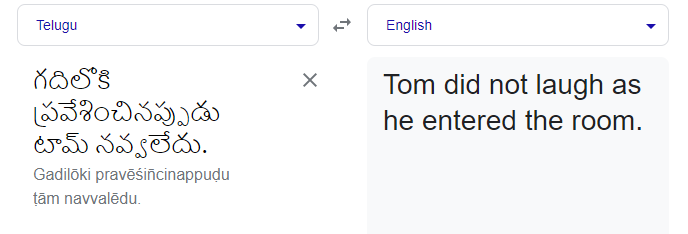

wts shape: dict_keys(['decoder_layer4_block1', 'decoder_layer4_block2'])
Input: గదిలోకి ప్రవేశించినప్పుడు టామ్ నవ్వలేదు.
Predicted translation: Tom didn't laugh when he entered the room.


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3095 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3110 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3135 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3122 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3147 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3093 missing from current font.
  font.set_text(s

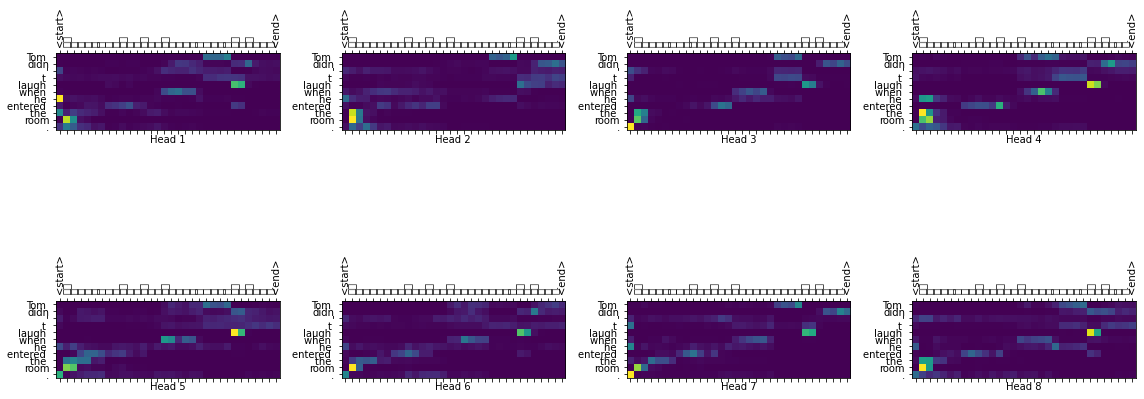

In [ ]:
translate("గదిలోకి ప్రవేశించినప్పుడు టామ్ నవ్వలేదు.", plot='decoder_layer4_block2')

**Google Translator**


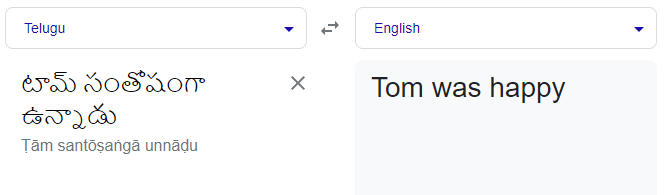

wts shape: dict_keys(['decoder_layer4_block1', 'decoder_layer4_block2'])
Input: టామ్ సంతోషంగా ఉన్నాడు
Predicted translation: Tom is unhappy.


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3103 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3134 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3118 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 3074 missing from current font.
  font.set_text(s

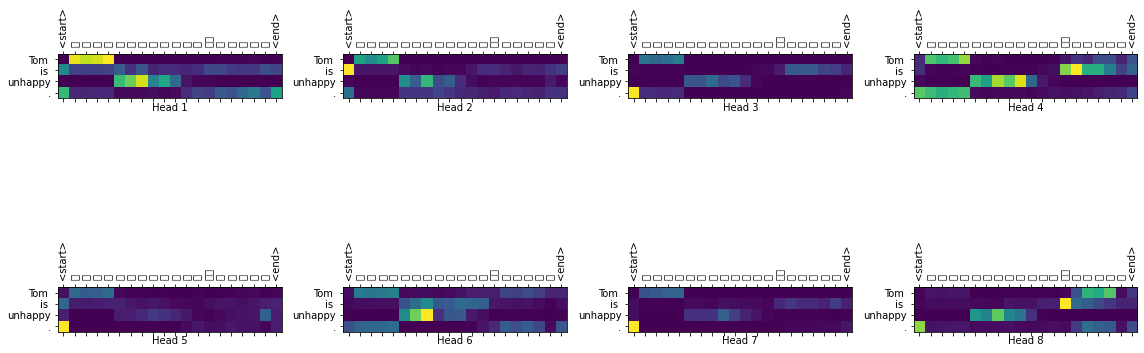

In [ ]:
translate("టామ్ సంతోషంగా ఉన్నాడు",plot='decoder_layer4_block2')

**Google Translator**
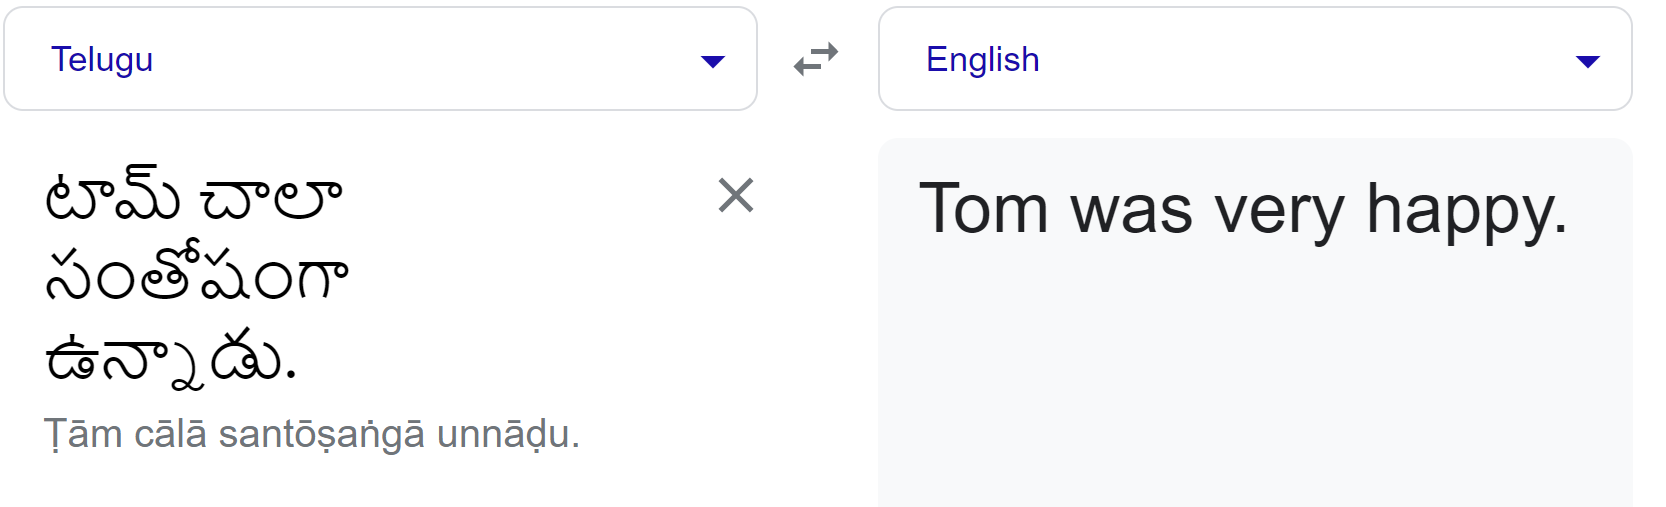

In [ ]:
translate("టామ్ చాలా సంతోషంగా ఉన్నాడు.")

wts shape: dict_keys(['decoder_layer4_block1', 'decoder_layer4_block2'])
Input: టామ్ చాలా సంతోషంగా ఉన్నాడు.
Predicted translation: Tom is very unhappy.


**Google Translator**
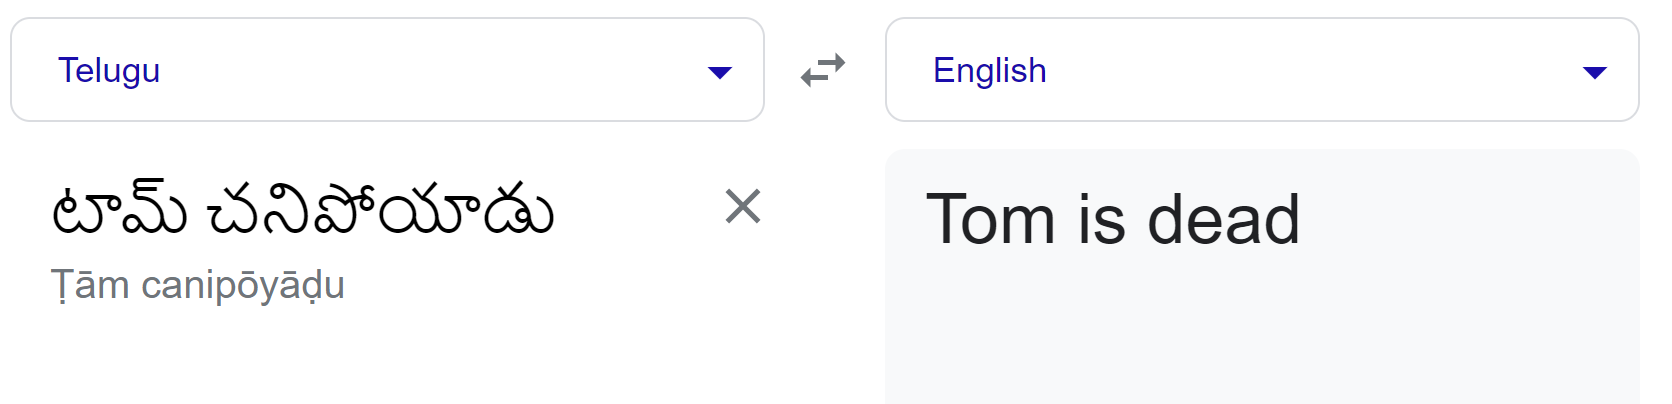

In [ ]:
translate("టామ్ చనిపోయాడు")

wts shape: dict_keys(['decoder_layer4_block1', 'decoder_layer4_block2'])
Input: టామ్ చనిపోయాడు
Predicted translation: Tom is dead.


**Google Translator**
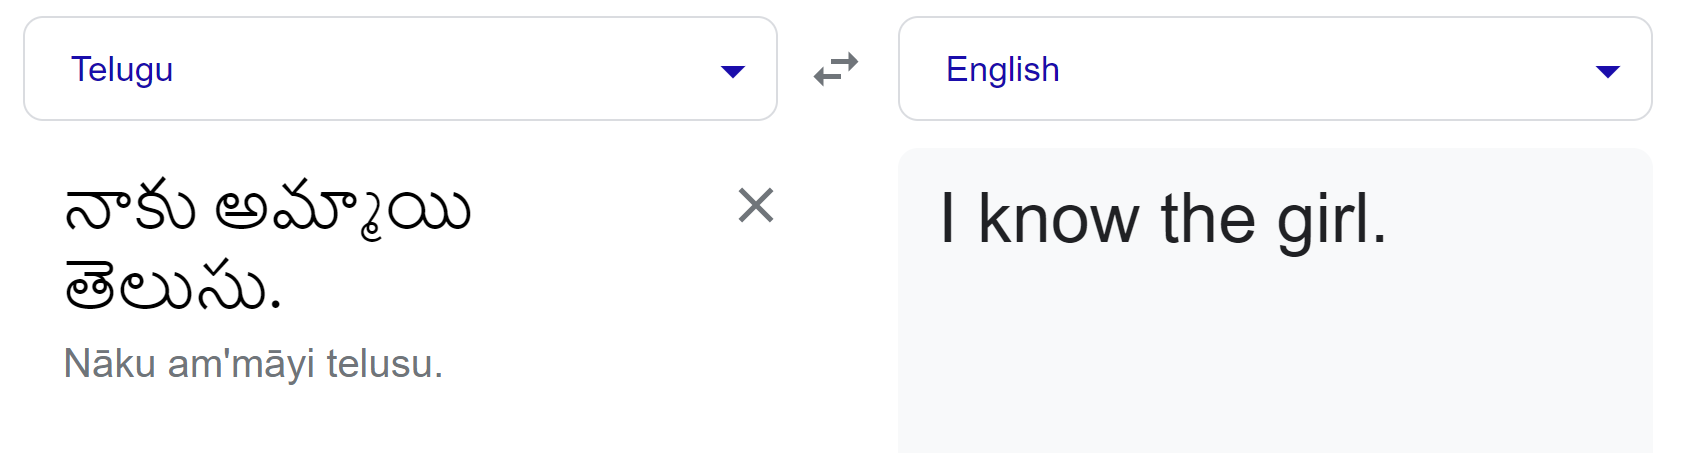

In [ ]:
translate("నాకు అమ్మాయి తెలుసు.")

wts shape: dict_keys(['decoder_layer4_block1', 'decoder_layer4_block2'])
Input: నాకు అమ్మాయి తెలుసు.
Predicted translation: I know the girl.


**Google Translator**

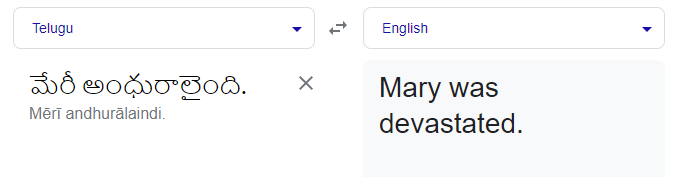

The above google translation is bad. Individual word translation of blind is given below.

when it comes to sentence translation, Google translator is giving different word for the telugu word "blind"

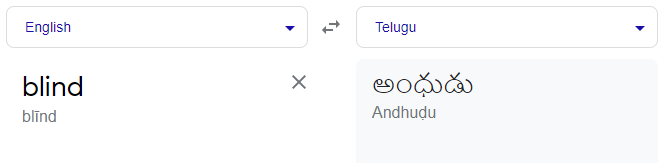


The individual word translation for the word devast is also given below.

Google translator gave bad translation for this sentence.

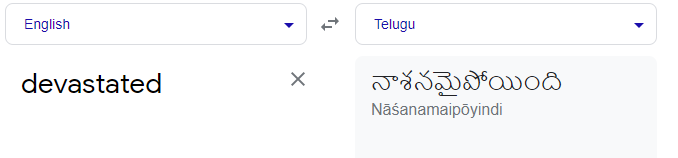


In [ ]:
translate("మేరీ అంధురాలైంది.")

wts shape: dict_keys(['decoder_layer4_block1', 'decoder_layer4_block2'])
Input: మేరీ అంధురాలైంది.
Predicted translation: Mary was blind.


**Google Translator**

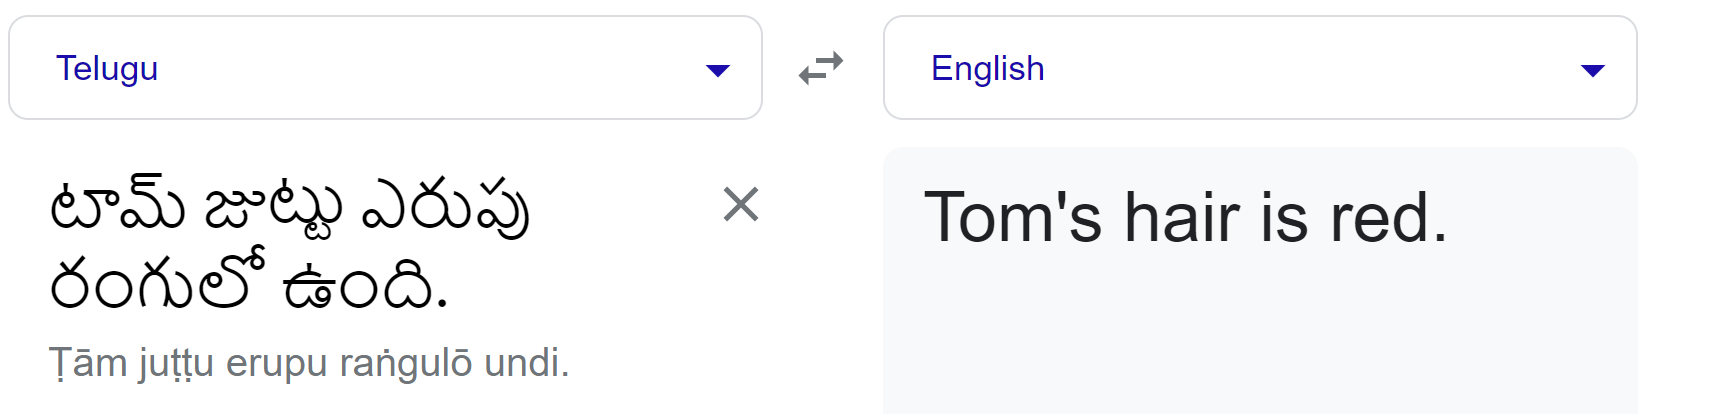

In [ ]:
translate(" టామ్ జుట్టు ఎరుపు రంగులో ఉంది.")

wts shape: dict_keys(['decoder_layer4_block1', 'decoder_layer4_block2'])
Input:  టామ్ జుట్టు ఎరుపు రంగులో ఉంది.
Predicted translation: Tom's hair is red.


**Google Translator**

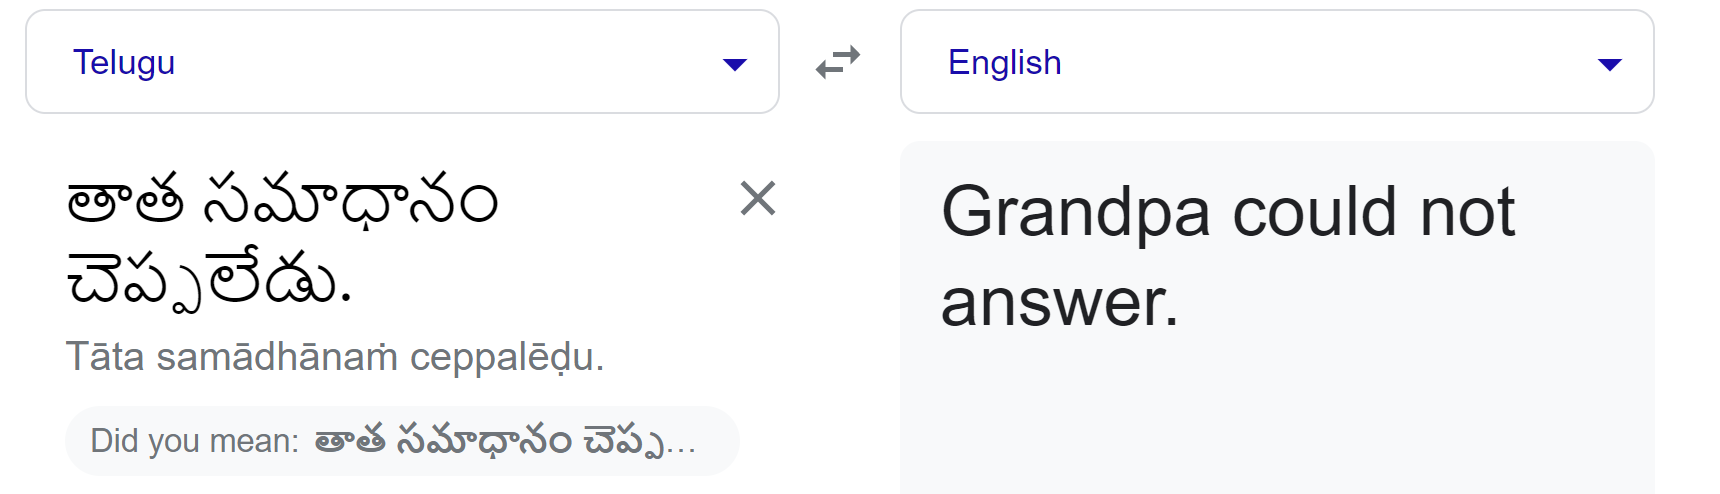

In [ ]:
translate(" తాత సమాధానం చెప్పలేడు.")

wts shape: dict_keys(['decoder_layer4_block1', 'decoder_layer4_block2'])
Input:  తాత సమాధానం చెప్పలేడు.
Predicted translation: The grandfather can't answer.


**Google Translator**
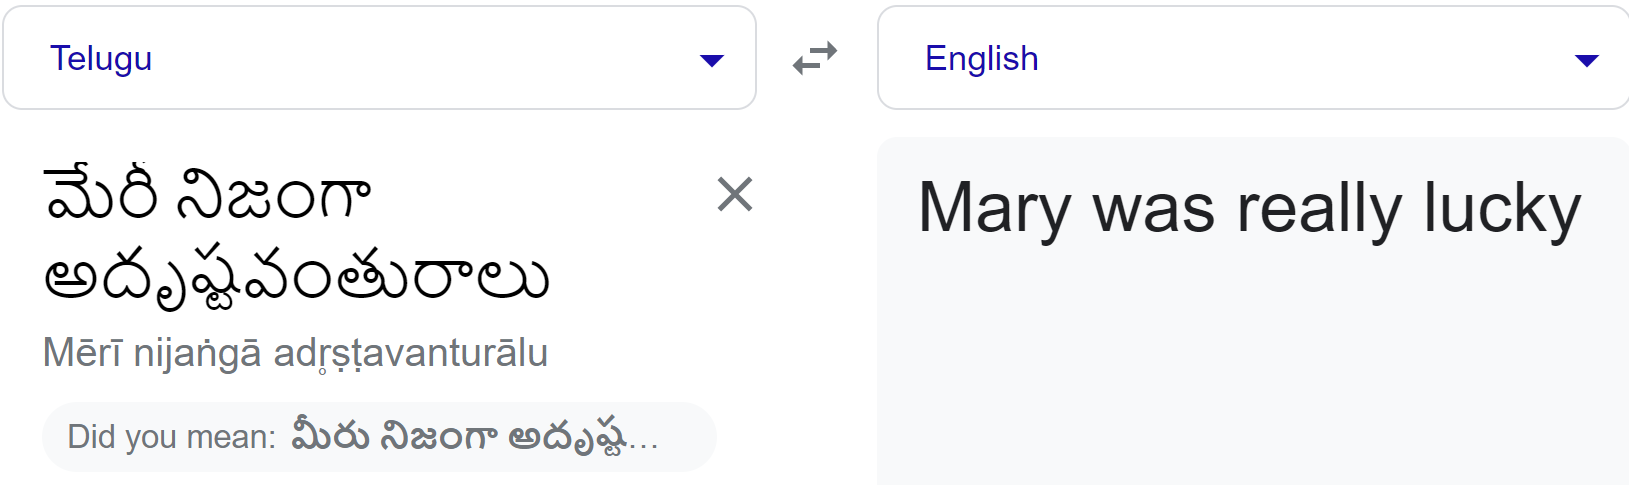

In [ ]:
translate("మేరీ నిజంగా అదృష్టవంతురాలు")

wts shape: dict_keys(['decoder_layer4_block1', 'decoder_layer4_block2'])
Input: మేరీ నిజంగా అదృష్టవంతురాలు
Predicted translation: Mary is really lucky.


**Google Translator**
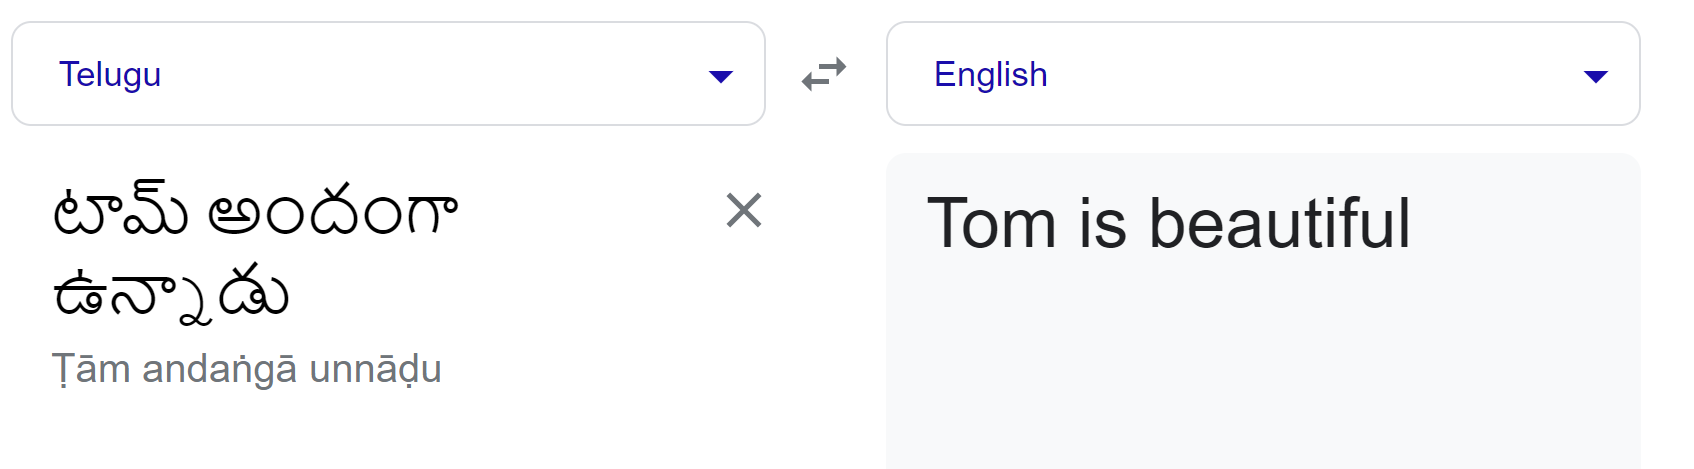

In [ ]:
translate("టామ్ అందంగా ఉన్నాడు")

wts shape: dict_keys(['decoder_layer4_block1', 'decoder_layer4_block2'])
Input: టామ్ అందంగా ఉన్నాడు
Predicted translation: Tom is pretty.


**Google Translator**
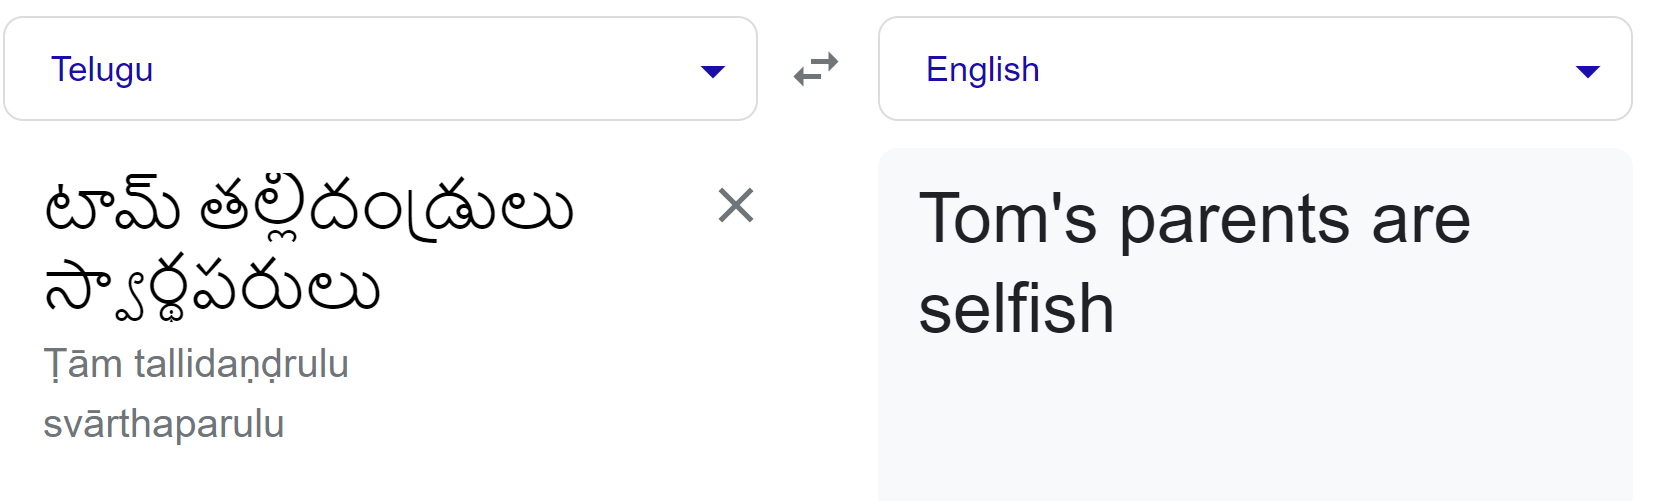

In [ ]:
translate("టామ్ తల్లిదండ్రులు స్వార్థపరులు")

wts shape: dict_keys(['decoder_layer4_block1', 'decoder_layer4_block2'])
Input: టామ్ తల్లిదండ్రులు స్వార్థపరులు
Predicted translation: Tom's parents are selfish.


**Google Translator**
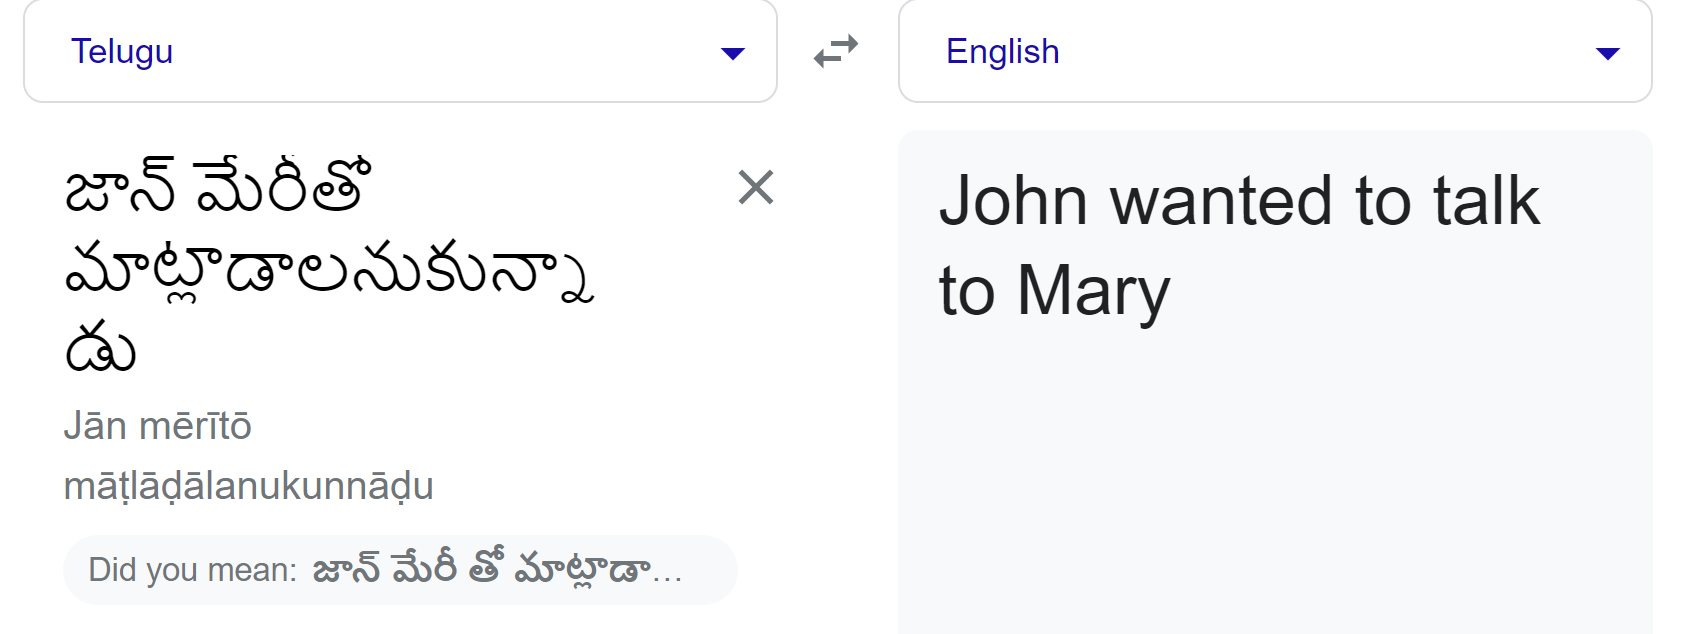

In [ ]:
translate("జాన్ మేరీతో మాట్లాడాలనుకున్నాడు")

wts shape: dict_keys(['decoder_layer4_block1', 'decoder_layer4_block2'])
Input: జాన్ మేరీతో మాట్లాడాలనుకున్నాడు
Predicted translation: John wanted to talk to Mary.


**Google Translator**

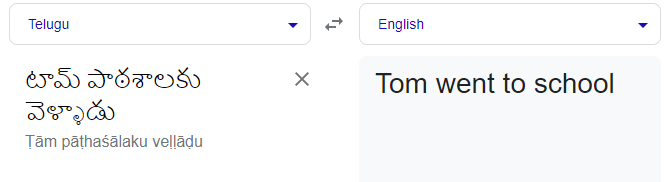

In [ ]:
translate("టామ్ పాఠశాలకు వెళ్ళాడు")

wts shape: dict_keys(['decoder_layer4_block1', 'decoder_layer4_block2'])
Input: టామ్ పాఠశాలకు వెళ్ళాడు
Predicted translation: Tom went to school.


**Google Translator**

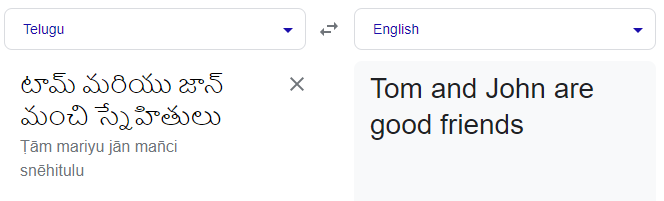

In [ ]:
translate("టామ్ మరియు జాన్ మంచి స్నేహితులు")

wts shape: dict_keys(['decoder_layer4_block1', 'decoder_layer4_block2'])
Input: టామ్ మరియు జాన్ మంచి స్నేహితులు
Predicted translation: Tom and John are good friends.


**Google Translator**

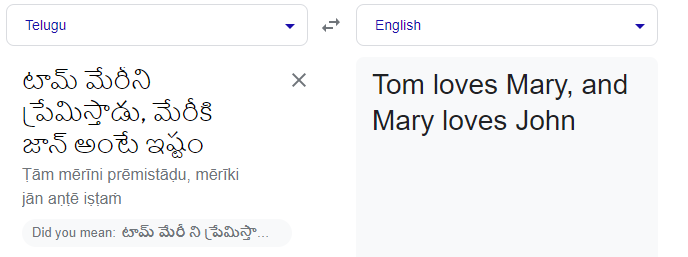

In [ ]:
translate("టామ్ మేరీని ప్రేమిస్తాడు, మేరీకి జాన్ అంటే ఇష్టం")

wts shape: dict_keys(['decoder_layer4_block1', 'decoder_layer4_block2'])
Input: టామ్ మేరీని ప్రేమిస్తాడు, మేరీకి జాన్ అంటే ఇష్టం
Predicted translation: Tom loves Mary, John or John.


**Google Translator**

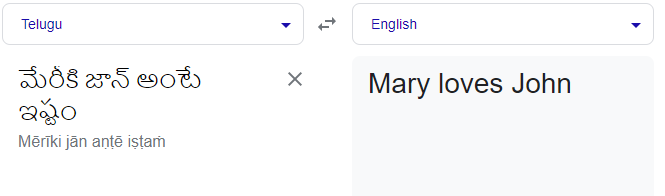

Google Translator considering the Telugu word "like" as "love" in the above translation.

The below image is the translation of individual word "like"

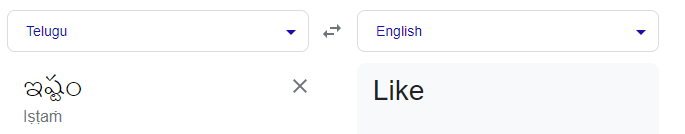

In [ ]:
translate("మేరీకి జాన్ అంటే ఇష్టం")

wts shape: dict_keys(['decoder_layer4_block1', 'decoder_layer4_block2'])
Input: మేరీకి జాన్ అంటే ఇష్టం
Predicted translation: Mary likes John.


**Google Translator**

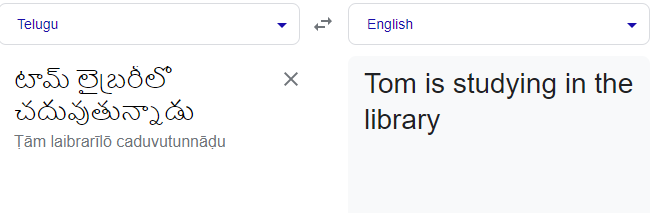

In [ ]:
translate("టామ్ లైబ్రరీలో చదువుతున్నాడు")

wts shape: dict_keys(['decoder_layer4_block1', 'decoder_layer4_block2'])
Input: టామ్ లైబ్రరీలో చదువుతున్నాడు
Predicted translation: Tom is reading in the library.


**Google Translator**

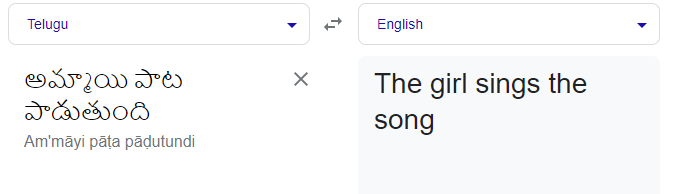

In [ ]:
translate("అమ్మాయి పాట పాడుతుంది")

wts shape: dict_keys(['decoder_layer4_block1', 'decoder_layer4_block2'])
Input: అమ్మాయి పాట పాడుతుంది
Predicted translation: The girl sings the song.


**Google Translator**


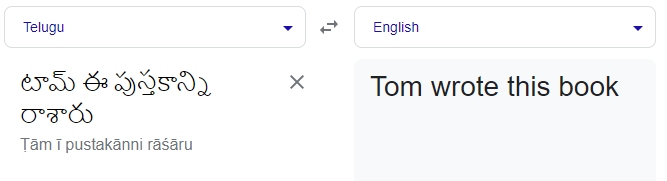

In [ ]:
translate("టామ్ ఈ పుస్తకాన్ని రాశారు")

wts shape: dict_keys(['decoder_layer4_block1', 'decoder_layer4_block2'])
Input: టామ్ ఈ పుస్తకాన్ని రాశారు
Predicted translation: Tom has written this book.


**Google Translator**

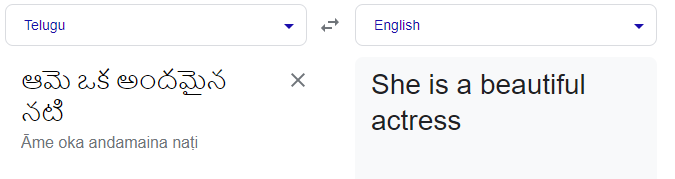

In [ ]:
translate("ఆమె ఒక అందమైన నటి")

wts shape: dict_keys(['decoder_layer4_block1', 'decoder_layer4_block2'])
Input: ఆమె ఒక అందమైన నటి
Predicted translation: She's a beautiful actor.


**Google Translator**

Google translation for this sentence is not good


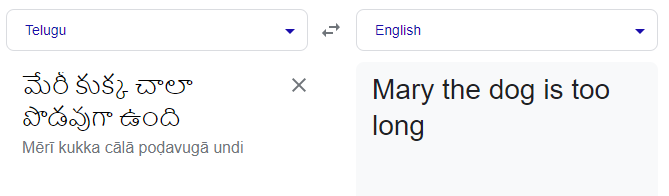

In [ ]:
translate("మేరీ కుక్క చాలా పొడవుగా ఉంది")

wts shape: dict_keys(['decoder_layer4_block1', 'decoder_layer4_block2'])
Input: మేరీ కుక్క చాలా పొడవుగా ఉంది
Predicted translation: Mary's dog is too long.


**Google Translator**

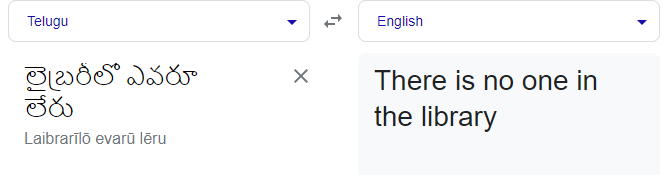

In [ ]:
translate("లైబ్రరీలో ఎవరూ లేరు")

wts shape: dict_keys(['decoder_layer4_block1', 'decoder_layer4_block2'])
Input: లైబ్రరీలో ఎవరూ లేరు
Predicted translation: There's no one in the library.


**Google Translator**

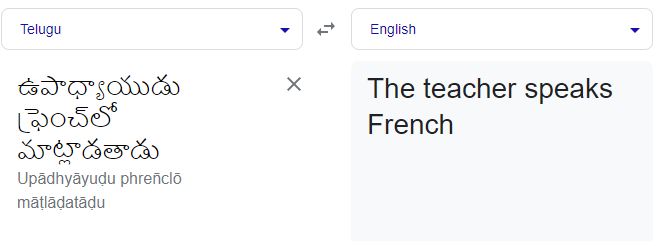

In [ ]:
translate("ఉపాధ్యాయుడు ఫ్రెంచ్‌లో మాట్లాడతాడు")

wts shape: dict_keys(['decoder_layer4_block1', 'decoder_layer4_block2'])
Input: ఉపాధ్యాయుడు ఫ్రెంచ్‌లో మాట్లాడతాడు
Predicted translation: The teacher speaks in French.


**Google Translator**


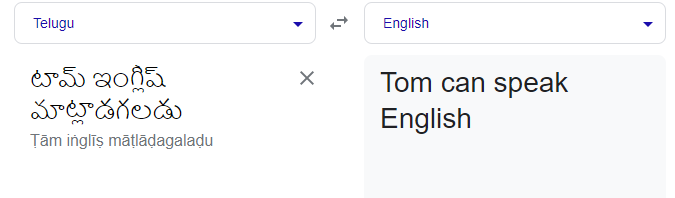

In [ ]:
translate("టామ్ ఇంగ్లీష్ మాట్లాడగలడు")

wts shape: dict_keys(['decoder_layer4_block1', 'decoder_layer4_block2'])
Input: టామ్ ఇంగ్లీష్ మాట్లాడగలడు
Predicted translation: Tom can speak English.


**Google Translator**

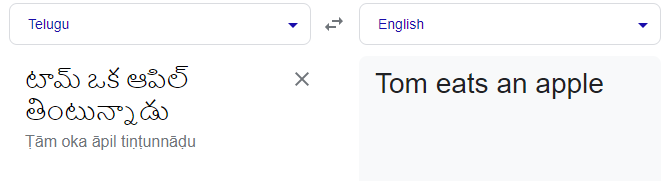

In [ ]:
translate("టామ్ ఒక ఆపిల్ తింటున్నాడు")

wts shape: dict_keys(['decoder_layer4_block1', 'decoder_layer4_block2'])
Input: టామ్ ఒక ఆపిల్ తింటున్నాడు
Predicted translation: Tom is eating an apple.
